In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# Question (1) (a) (b)

In [2]:
full_dataset = tf.keras.preprocessing.image_dataset_from_directory('../data/images',
                                                                   label_mode='categorical',
                                                                   batch_size=5,
                                                                   image_size=(224, 224))

Found 1236 files belonging to 21 classes.


In [3]:
full_dataset_size = len(list(full_dataset))
train_dataset_size = int(0.7 * full_dataset_size)
validate_dataset_size = int(0.15 * full_dataset_size)

train_dataset = full_dataset.take(train_dataset_size)
remaining = full_dataset.skip(train_dataset_size)  
validate_dataset = remaining.take(validate_dataset_size)
test_dataset = remaining.skip(validate_dataset_size)

2022-12-10 15:04:15.348503: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validate_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 173
Number of validation batches: 37
Number of test batches: 38


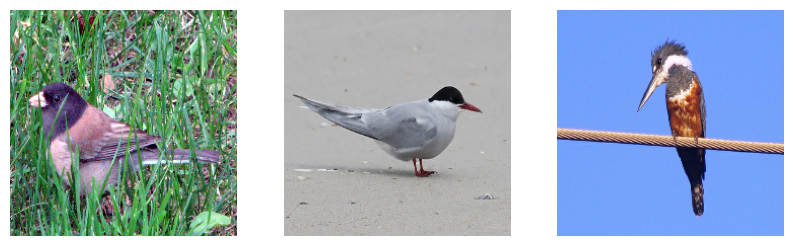

In [5]:
# class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validate_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Question (1) (c)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(height=224, width=224),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.2)),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])

2022-12-10 15:04:17.557942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-10 15:04:19.201348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-10 15:04:20.791350: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-10 15:04:22.433988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-10 15:04:24.008226: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-10 15:04:25.651370: W tensorflow/core/grappler/optimizers/loop_opti

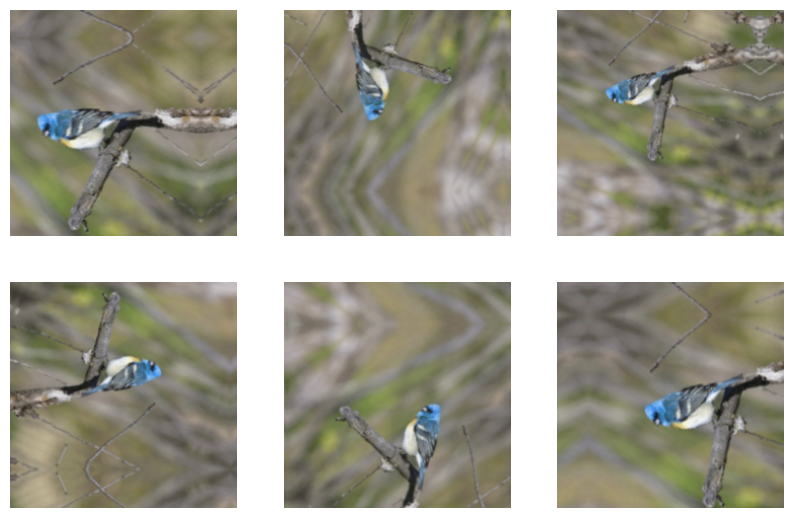

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# `EfficientNetB0`

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 7, 7, 1280)


In [11]:
base_model.trainable = False

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(21, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 21)


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(name='EfficientNetB0', inputs=inputs, outputs=outputs)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [16]:
model.summary()

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1280)              1639680   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                    

In [17]:
len(model.trainable_variables)

4

In [18]:
loss0, accuracy0, precision0, recall0 = model.evaluate(validate_dataset)

37/37 [==============================] - 4s 72ms/step - loss: 3.0659 - accuracy: 0.0486 - precision: 0.0000e+00 - recall: 0.0000e+00


In [19]:
print('EffecientNetB0:')
print("Initial Loss: {:.2f}".format(loss0))
print("Initial Accuracy: {:.2f}".format(accuracy0))
print("Initial Precision: {:.2f}".format(precision0))
print("Initial Recall: {:.2f}".format(recall0))

EffecientNetB0:
Initial Loss: 3.07
Initial Accuracy: 0.05
Initial Precision: 0.00
Initial Recall: 0.00


In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validate_dataset,
                    callbacks=[callback])

Epoch 1/100


2022-12-10 15:04:37.918683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: EfficientNetB0/sequential/random_crop/loop_body/cond/branch_executed/_9


173/173 [==============================] - 25s 114ms/step - loss: 1.2626 - accuracy: 0.6254 - precision: 0.7714 - recall: 0.5110 - val_loss: 0.4592 - val_accuracy: 0.8432 - val_precision: 0.9012 - val_recall: 0.7892
Epoch 2/100
173/173 [==============================] - 19s 110ms/step - loss: 0.4656 - accuracy: 0.8543 - precision: 0.8929 - recall: 0.8197 - val_loss: 0.4460 - val_accuracy: 0.8811 - val_precision: 0.8960 - val_recall: 0.8378
Epoch 3/100
173/173 [==============================] - 21s 120ms/step - loss: 0.3838 - accuracy: 0.8821 - precision: 0.9108 - recall: 0.8613 - val_loss: 0.4076 - val_accuracy: 0.8919 - val_precision: 0.9101 - val_recall: 0.8757
Epoch 4/100
173/173 [==============================] - 20s 118ms/step - loss: 0.3527 - accuracy: 0.8809 - precision: 0.8975 - recall: 0.8705 - val_loss: 0.3439 - val_accuracy: 0.9081 - val_precision: 0.9121 - val_recall: 0.8973
Epoch 5/100
173/173 [==============================] - 20s 118ms/step - loss: 0.2817 - accuracy: 0.9

Epoch 37/100
173/173 [==============================] - 22s 128ms/step - loss: 0.0768 - accuracy: 0.9792 - precision: 0.9803 - recall: 0.9792 - val_loss: 0.7804 - val_accuracy: 0.9135 - val_precision: 0.9135 - val_recall: 0.9135
Epoch 38/100
173/173 [==============================] - 22s 130ms/step - loss: 0.0334 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - val_loss: 0.4898 - val_accuracy: 0.9297 - val_precision: 0.9297 - val_recall: 0.9297
Epoch 39/100
173/173 [==============================] - 21s 120ms/step - loss: 0.0563 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - val_loss: 0.6460 - val_accuracy: 0.9135 - val_precision: 0.9185 - val_recall: 0.9135
Epoch 40/100
173/173 [==============================] - 21s 121ms/step - loss: 0.0945 - accuracy: 0.9803 - precision: 0.9826 - recall: 0.9792 - val_loss: 0.8227 - val_accuracy: 0.9135 - val_precision: 0.9135 - val_recall: 0.9135
Epoch 41/100
173/173 [==============================] - 20s 117ms/step - loss: 0.144

Epoch 73/100
173/173 [==============================] - 18s 102ms/step - loss: 0.0706 - accuracy: 0.9803 - precision: 0.9815 - recall: 0.9803 - val_loss: 1.3635 - val_accuracy: 0.8973 - val_precision: 0.8973 - val_recall: 0.8973
Epoch 74/100
173/173 [==============================] - 18s 106ms/step - loss: 0.1523 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - val_loss: 0.9442 - val_accuracy: 0.8973 - val_precision: 0.8973 - val_recall: 0.8973
Epoch 75/100
173/173 [==============================] - 19s 108ms/step - loss: 0.1091 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - val_loss: 0.6982 - val_accuracy: 0.9405 - val_precision: 0.9405 - val_recall: 0.9405
Epoch 76/100
173/173 [==============================] - 18s 107ms/step - loss: 0.0694 - accuracy: 0.9815 - precision: 0.9826 - recall: 0.9815 - val_loss: 1.0100 - val_accuracy: 0.9459 - val_precision: 0.9459 - val_recall: 0.9459
Epoch 77/100
173/173 [==============================] - 18s 107ms/step - loss: 0.135

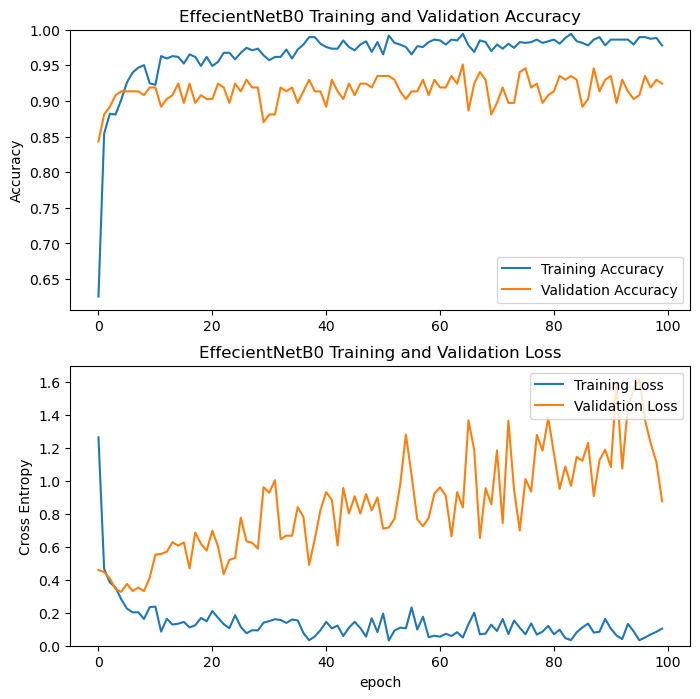

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('EffecientNetB0 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('EffecientNetB0 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print('EffecientNetB0')
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)
print('Test Precision:', precision)
print('Test Recall:', recall)

38/38 [==============================] - 3s 66ms/step - loss: 1.1544 - accuracy: 0.9140 - precision: 0.9189 - recall: 0.9140
EffecientNetB0
Test Accuracy: 0.9139785170555115
Test Loss: 1.1544480323791504
Test Precision: 0.9189189076423645
Test Recall: 0.9139785170555115


# `VGG16`

In [23]:
base_model = tf.keras.applications.VGG16(include_top=False)

In [24]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 7, 7, 512)


In [25]:
base_model.trainable = False

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 512)


In [27]:
prediction_layer = tf.keras.layers.Dense(21, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 21)


In [28]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(name='VGG16', inputs=inputs, outputs=outputs)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [30]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [31]:
len(model.trainable_variables)

4

In [32]:
loss0, accuracy0, precision0, recall0 = model.evaluate(validate_dataset)

37/37 [==============================] - 12s 299ms/step - loss: 11.5945 - accuracy: 0.0541 - precision_1: 0.0637 - recall_1: 0.0541


In [33]:
print('VGG16')
print("Initial Loss: {:.2f}".format(loss0))
print("Initial Accuracy: {:.2f}".format(accuracy0))
print("Initial Precision: {:.2f}".format(precision0))
print("Initial Recall: {:.2f}".format(recall0))

VGG16
Initial Loss: 11.59
Initial Accuracy: 0.05
Initial Precision: 0.06
Initial Recall: 0.05


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validate_dataset,
                    callbacks=[callback])

Epoch 1/100


2022-12-10 15:37:46.952843: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: VGG16/sequential/random_crop/loop_body/cond/branch_executed/_9


173/173 [==============================] - 73s 400ms/step - loss: 3.9452 - accuracy: 0.2220 - precision_1: 0.2761 - recall_1: 0.1561 - val_loss: 2.4855 - val_accuracy: 0.4703 - val_precision_1: 0.5271 - val_recall_1: 0.3676
Epoch 2/100
173/173 [==============================] - 67s 385ms/step - loss: 1.9127 - accuracy: 0.4439 - precision_1: 0.5604 - recall_1: 0.2948 - val_loss: 1.6421 - val_accuracy: 0.5892 - val_precision_1: 0.6400 - val_recall_1: 0.5189
Epoch 3/100
173/173 [==============================] - 66s 382ms/step - loss: 1.4857 - accuracy: 0.5653 - precision_1: 0.6844 - recall_1: 0.4312 - val_loss: 1.6193 - val_accuracy: 0.6000 - val_precision_1: 0.6405 - val_recall_1: 0.5297
Epoch 4/100
173/173 [==============================] - 66s 381ms/step - loss: 1.1983 - accuracy: 0.6405 - precision_1: 0.7504 - recall_1: 0.5318 - val_loss: 1.5009 - val_accuracy: 0.6541 - val_precision_1: 0.7039 - val_recall_1: 0.5784
Epoch 5/100
173/173 [==============================] - 66s 383ms/ste

Epoch 36/100
173/173 [==============================] - 66s 381ms/step - loss: 0.4626 - accuracy: 0.8717 - precision_1: 0.8850 - recall_1: 0.8543 - val_loss: 2.6313 - val_accuracy: 0.6811 - val_precision_1: 0.6868 - val_recall_1: 0.6757
Epoch 37/100
173/173 [==============================] - 66s 380ms/step - loss: 0.4305 - accuracy: 0.8647 - precision_1: 0.8894 - recall_1: 0.8555 - val_loss: 2.3917 - val_accuracy: 0.7027 - val_precision_1: 0.7095 - val_recall_1: 0.6865
Epoch 38/100
173/173 [==============================] - 65s 378ms/step - loss: 0.2824 - accuracy: 0.9121 - precision_1: 0.9250 - recall_1: 0.8983 - val_loss: 2.5081 - val_accuracy: 0.7135 - val_precision_1: 0.7360 - val_recall_1: 0.7081
Epoch 39/100
173/173 [==============================] - 65s 378ms/step - loss: 0.3669 - accuracy: 0.8890 - precision_1: 0.9055 - recall_1: 0.8751 - val_loss: 2.3229 - val_accuracy: 0.7027 - val_precision_1: 0.7263 - val_recall_1: 0.7027
Epoch 40/100
173/173 [==============================

173/173 [==============================] - 65s 377ms/step - loss: 0.2369 - accuracy: 0.9422 - precision_1: 0.9472 - recall_1: 0.9329 - val_loss: 2.7154 - val_accuracy: 0.7405 - val_precision_1: 0.7486 - val_recall_1: 0.7405
Epoch 71/100
173/173 [==============================] - 65s 377ms/step - loss: 0.2218 - accuracy: 0.9341 - precision_1: 0.9426 - recall_1: 0.9295 - val_loss: 2.6964 - val_accuracy: 0.7568 - val_precision_1: 0.7554 - val_recall_1: 0.7514
Epoch 72/100
173/173 [==============================] - 65s 377ms/step - loss: 0.3589 - accuracy: 0.9121 - precision_1: 0.9192 - recall_1: 0.9075 - val_loss: 2.6299 - val_accuracy: 0.7730 - val_precision_1: 0.7717 - val_recall_1: 0.7676
Epoch 73/100
173/173 [==============================] - 65s 377ms/step - loss: 0.2420 - accuracy: 0.9341 - precision_1: 0.9437 - recall_1: 0.9295 - val_loss: 2.8155 - val_accuracy: 0.7676 - val_precision_1: 0.7747 - val_recall_1: 0.7622
Epoch 74/100
173/173 [==============================] - 65s 378ms

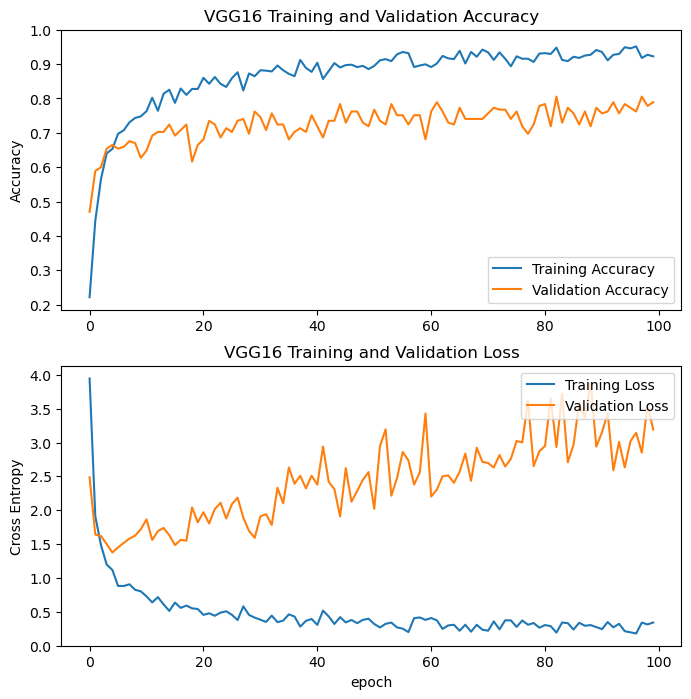

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('VGG16 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print('VGG16:')
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)
print('Test Precision:', precision)
print('Test Recall:', recall)

38/38 [==============================] - 12s 294ms/step - loss: 3.0250 - accuracy: 0.7312 - precision_1: 0.7418 - recall_1: 0.7258
VGG16:
Test Accuracy: 0.7311828136444092
Test Loss: 3.0250391960144043
Test Precision: 0.7417582273483276
Test Recall: 0.725806474685669
